## Prepare Data

In [1]:
# First install package from terminal:
!pip install -U pip
!pip install -U setuptools wheel
!pip install autogluon  # autogluon==0.4.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.1 MB 14.5 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 34.0 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 57.4.0
    Uninstalling setuptools-57.4.0:
      Successfully uninstalled setuptools-57.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/

In [2]:
# import all required modules
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer

pd.set_option('display.max_rows', None)  ###
pd.set_option('display.max_columns', None)  ###
pd.set_option('display.width', None)  ###
pd.set_option('display.max_colwidth', None)  ###

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import auc
from sklearn.metrics import cohen_kappa_score
from sklearn.inspection import permutation_importance

In [3]:
# connect colab with google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# import dataset
file = '/content/drive/MyDrive/MIMIC-III Text Mining/LOS/data/df_mixed_discharge.csv'
raw_df = pd.read_csv(file, low_memory=False)

In [5]:
# examine the variables (names)
raw_df.columns

Index(['Unnamed: 0', 'HADM_ID', 'subject_id', 'ethnicity', 'admission_type',
       'admission_location', 'insurance', 'religion', 'marital_status',
       'icu_los', 'gender', 'age', 'urea_n_min', 'urea_n_max', 'urea_n_mean',
       'platelets_min', 'platelets_max', 'platelets_mean', 'magnesium_max',
       'albumin_min', 'calcium_min', 'resprate_min', 'resprate_max',
       'resprate_mean', 'glucose_min', 'glucose_max', 'glucose_mean', 'hr_min',
       'hr_max', 'hr_mean', 'sysbp_min', 'sysbp_max', 'sysbp_mean',
       'diasbp_min', 'diasbp_max', 'diasbp_mean', 'temp_min', 'temp_max',
       'temp_mean', 'sapsii', 'sofa', 'urine_min', 'urine_mean', 'urine_max',
       'patientweight', 'readmit_dt', 'age_cat', 'type_stay', 'prev_adm',
       'emergency_dpt', 'icd_chapter', 'origin_patient', 'los',
       'dest_discharge', 'discharge'],
      dtype='object')

In [6]:
# drop the variables to be exempted from the analysis and rename new dataset
df = raw_df.drop(columns = ['Unnamed: 0', 'HADM_ID', 'subject_id','icu_los'])


In [7]:
# selection criterion : only patients 18 and older and with a length of stay or 1 day or greater
df = df.loc[(df['age']>=18) & (df['los']>=1),:]
# compare size of dataframe before and after selection
len(raw_df), len(df)

(39841, 39105)

In [8]:
# check proportion of missing values
missing = pd.DataFrame(df.isna().mean(), columns = ['proportions'])
missing.sort_values('proportions',ascending = False)

,proportions
patientweight,0.515177
albumin_min,0.313771
type_stay,0.251477
calcium_min,0.024728
glucose_min,0.002966
glucose_mean,0.002966
glucose_max,0.002966
magnesium_max,0.002839
temp_mean,0.001585
temp_max,0.001585


In [9]:
# drop variables having more than 20 % missing values
df = df.drop(columns=['albumin_min','patientweight','type_stay'])

In [10]:
# save df
df_copy = df.copy()

In [11]:
# impute missing values
df = df_copy.interpolate()
df.isna().mean()

ethnicity             0.0
admission_type        0.0
admission_location    0.0
insurance             0.0
religion              0.0
marital_status        0.0
gender                0.0
age                   0.0
urea_n_min            0.0
urea_n_max            0.0
urea_n_mean           0.0
platelets_min         0.0
platelets_max         0.0
platelets_mean        0.0
magnesium_max         0.0
calcium_min           0.0
resprate_min          0.0
resprate_max          0.0
resprate_mean         0.0
glucose_min           0.0
glucose_max           0.0
glucose_mean          0.0
hr_min                0.0
hr_max                0.0
hr_mean               0.0
sysbp_min             0.0
sysbp_max             0.0
sysbp_mean            0.0
diasbp_min            0.0
diasbp_max            0.0
diasbp_mean           0.0
temp_min              0.0
temp_max              0.0
temp_mean             0.0
sapsii                0.0
sofa                  0.0
urine_min             0.0
urine_mean            0.0
urine_max   

#### EDA

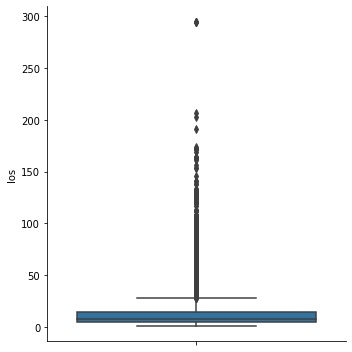

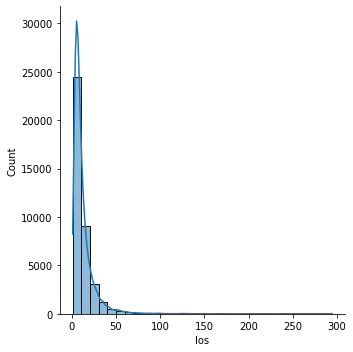

In [12]:
# check distribution of outcome
sns.catplot(kind='box', data=df, y='los');
sns.displot(data=df, x="los", bins=30, kde=True) ;

In [13]:
# compute Lower and Upper Fence according to Tukey's criteria
y = df['los']
Q1 = np.percentile(y, 25)
Q3 = np.percentile(y, 75)
IQR = Q3-Q1
LF = Q1 - 1.5*IQR
UF = Q3 + 1.5*IQR
print(f'First quartile = {Q1:.3f}, Third Quartile = {Q3:.3f}, Interquartile Interval = {IQR:.3f}')
print(f'Lower Fence = {LF:.3f}, Upper Fence = {UF:.3f}')

First quartile = 5.142, Third Quartile = 14.506, Interquartile Interval = 9.365
Lower Fence = -8.905, Upper Fence = 28.553


In [14]:
# create categorical LOS variable where prolonged LOS is any value greater than Upper Fence
df['los_cat'] = df['los']> UF

## Heavier Preprocessing

In [15]:
# PARAMETERS

preprocessing = False # set to true if we want to clean and perform some preprocessing
preproc_heavier = False # set to True if we want a heavier preprocessing
preproc_tag_2 = np.where(preproc_heavier, '_heavier', '')
preproc_tag = np.where(preprocessing, f'_preproc{preproc_tag_2}', f'{preproc_tag_2}')

In [16]:
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [17]:
try:
  from unidecode import unidecode
except:
  !pip install unidecode
  from unidecode import unidecode

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.9/235.9 kB 14.2 MB/s eta 0:00:00


In [18]:
stemmer = SnowballStemmer("english", ignore_stopwords=True) # we initialize our stemmer
stop_words = stopwords.words('english') # nltk stopwords

In [19]:
def remove_stopwords(text):
    text =  " ".join([x for x in text.split()if x not in stop_words]) # delete stopwords from text
    return text

def heading_clean(text):
  text = re.sub(r'\[\*\*(.+?)\*\*\]', "", text) # we take out information in brackets
  text = re.sub(r'(Admission Date:)|(Discharge Date:)|(Date of Birth:)|(Name:)|(Unit No:)', "", text, flags = re.I)
  if preproc_heavier:
    text = re.sub(r'Sex:', "", text, flags = re.I)
    text = text.lower() # lowercase text
    text = unidecode((text))
    text = re.sub(r'[^\w\s]','',text)
    text =  " ".join([stemmer.stem(x) for x in text.split()])
    text = remove_stopwords(text)
  return text

In [20]:
if preprocessing:
  try:
    df = pd.read_feather(f'/content/drive/MyDrive/MIMIC-III Text Mining/LOS/data/df_los{preproc_tag}')
    print('Dataframe Loaded')
  except:
    df['discharge'] = df.discharge.apply(lambda x: heading_clean(x))
    # need to reset the index
    df.reset_index(inplace=True, drop = True)
    # save our dataset up to now in feather format
    df.to_feather(f'/content/drive/MyDrive/MIMIC-III Text Mining/LOS/data/df_los{preproc_tag}')
    print('Dataframe Saved')

In [21]:
# restrict to just discharge notes
df = df[['los_cat', 'discharge']]

## Train/Test Split

In [22]:
# split the data into training and test
df_train, df_test = train_test_split(df, train_size=0.80, stratify = df['los_cat'], random_state=42)

In [23]:
df_train.shape, df_test.shape

((31284, 2), (7821, 2))

## Train the Tabular Model (Structured DataSet)

In [24]:
# paramètres du modèle
if preprocessing:
  save_path = f'/content/drive/MyDrive/MIMIC-III Text Mining/LOS/models/text_only{preproc_tag}'
  print('With Preprocessing')
else:
  save_path = '/content/drive/MyDrive/AutoGluon/models/text_only_202-05-29'
  print('Without Preprocessing')

label = 'los_cat'
metric = 'roc_auc'

Without Preprocessing


In [25]:
# run the tabular predictor ensemble of models (include 'multimodal' hyperparameter)
from autogluon.text import TextPredictor

try:
  predictor = TextPredictor.load(save_path)
  print("Model Loaded")
except:
  print("Training Model")
  predictor = TextPredictor(label=label, eval_metric=metric, path=save_path)
  predictor.fit(
      train_data=df_train,
      hyperparameters={
          "model.hf_text.checkpoint_name": "emilyalsentzer/Bio_ClinicalBERT", 
      },
  )

Downloading:   0%|          | 0.00/385 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Load pretrained checkpoint: /content/drive/MyDrive/AutoGluon/models/text_only_202-05-29/model.ckpt


Model Loaded


In [26]:
# evaluate performance on the test set
per_tab = predictor.evaluate(df_test, metrics=['roc_auc','f1','acc'])
per_tab

Predicting: 0it [00:00, ?it/s]

{'acc': 0.9836338064186165,
 'f1': 0.8825688073394495,
 'roc_auc': 0.9883719771056833}

In [27]:
# save the class and probability predictions
y_pred = predictor.predict(df_test)
y_pred_proba = predictor.predict_proba(df_test).iloc[:,1]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

In [28]:
# compute other metrics
def perf(y_test, y_pred, y_pred_proba):
  kappa = cohen_kappa_score(y_test, y_pred)
  precision, recall, prc_th = precision_recall_curve(y_test, y_pred_proba)
  prc_auc = auc(recall, precision)
  return kappa, prc_auc

perf = perf(df_test['los_cat'], y_pred, y_pred_proba)
perf_dict = {"Cohen's Kappa": perf[0], "PRC AUC": perf[1]}
perf_dict

{"Cohen's Kappa": 0.8738163285216329, 'PRC AUC': 0.9353072556693518}

In [29]:
# path to save all the results
if preprocessing:
  path_results = f'/content/drive/MyDrive/MIMIC-III Text Mining/LOS/results/text_only'
else:
  #path_results = '/content/drive/MyDrive/AutoGluon/results/text_only_2022-05-29'

In [30]:
perf_dict.update(per_tab)

In [31]:
# save performances
df_perf = pd.DataFrame.from_dict(perf_dict, orient='index', columns=['performances'])
df_perf.to_excel(path_results+f'/df_perf{preproc_tag}.xlsx')

In [32]:
from sklearn.metrics import confusion_matrix, classification_report

In [33]:
df_test.los_cat.value_counts()

False    7239
True      582
Name: los_cat, dtype: int64

Test Set I 

              precision    recall  f1-score   support

       Short      0.986     0.996     0.991      7239
        Long      0.947     0.826     0.883       582

    accuracy                          0.984      7821
   macro avg      0.967     0.911     0.937      7821
weighted avg      0.983     0.984     0.983      7821



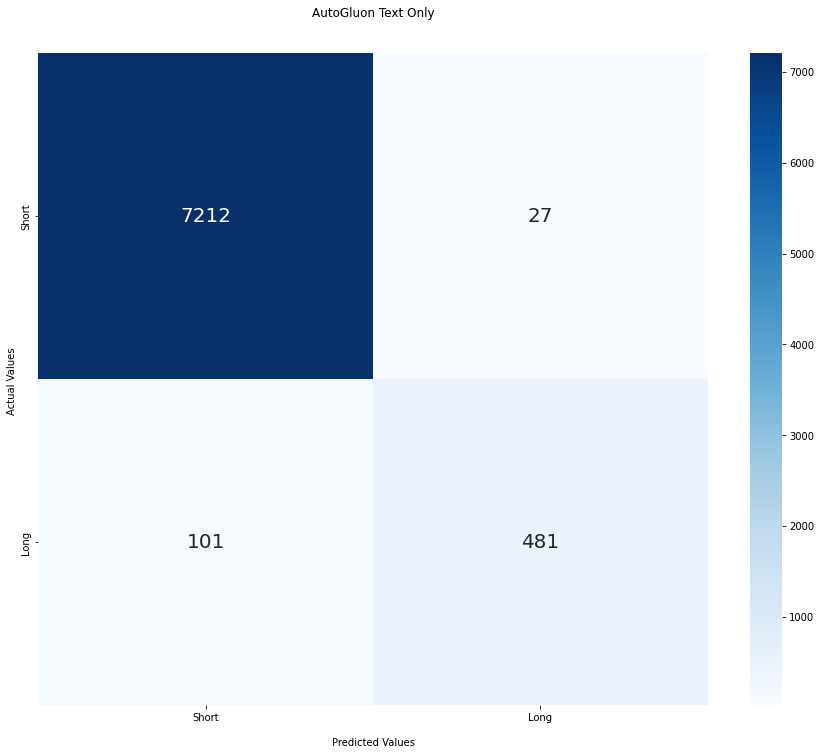

In [34]:
cm = confusion_matrix(list(df_test.los_cat), list(y_pred), labels=[0,1])

print('Test Set I \n')
print(classification_report(list(df_test.los_cat), list(y_pred), target_names=['Short','Long',], digits = 3))

plt.figure(figsize=(15,12))

ax = sns.heatmap(cm, annot=True, cmap='Blues', fmt = 'g', annot_kws={"fontsize":20})

ax.set_title('AutoGluon Text Only\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Short','Long'])
ax.yaxis.set_ticklabels(['Short','Long'])

## Display the visualization of the Confusion Matrix.
plt.show()